> # Neural Network Basic - Week3 과제


## Import Library

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from mnist import load_mnist

## Load Dataset
- MNIST 

In [17]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [18]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [28]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        return 1/(1+np.exp(-x))
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        return x*(1-x) 

In [20]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        if x>0:
            return x
        else:
            return 0
        
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        if x>0:
            return 1
        else:
            return 0  

In [21]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [22]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [23]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [29]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr #학습률이다. 모델의 학습정도를 조절하는 파라미터로 로컬미니멈에 도달하기 위해 적절히 조절해주어야함. 
        self.epoch = epoch #epoch사이즈. 순전파와 역전파가 한세트로 일어나면 한 에포크를 돌았다고 한다. 즉, 데이터가 한번 학습된것을 1
                           #1에포크를 수행했다고 말할 수 있다. 
        self.batch_size = batch_size #배치사이즈. 전체데이터를 몇개의 배치사이즈로 나누어 학습할지 정한다. 
        self.loss_function = cross_entropy #손실함수를 무엇으로 사용할지
        self.layers = [] #층을 담을 공간이다. 
        self.activations = [softmax] #활성화함수를 무엇을 사용할지 정한다. 
        self.nodes = []
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) 
        if not self.nodes: #self.node가 비어있다면, 즉 층을 처음 연결하는 것이라면 
            self.nodes.append(np.zeros(Layer.input_size)) #쌓을 층의 input사이즈만큼 0을 채워 넣는다. 
        self.nodes.append(np.zeros(Layer.output_size)) #처음 연결이 아니라면 층의 output사이즈만큼 0을 채워넣는다. 
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop() #마지막엔 무조건 소프트맥스함수를 사용할 것이므로 tmp에 스포트맥스함수 담아놓고 activation리스트는 
                                     #비워둔 다음 
        self.activations.append(Activation) #추가할 activation을 넣어주고 
        self.activations.append(tmp) #비워주었던 소프트맥스를 맨끝에 다시 넣는다. 
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() 
        output = X.copy() 
        for i in range(len(self.layers)): 
            Layer = self.layers[i] #층은 만들어놓은 layers리스트에서 i번째꺼 가져오기 
            Activation = self.activations[i] #활성화함수도 activation리스트에서 i번째 가져오기 
            output = np.dot(self.nodes[i], Layer.weight) #예측값은 x값과 층의 가중치를 내적한것 
            output = output+ Layer.bias #편향 더해주기 
            output = Activation.forward(output) #정해놓은 활성화함수로 순전파 학습 진행 
            self.nodes[i+1] = output #노드의 다음층은 이 층에서 학습한뒤 만들어진 output이다. 
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): 
            a = self.nodes[i+1] #output값 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            
            if i+1 == len(self.layers): #마지막층에서 역전파이면 
                error = Activation.backward(output, y)
            else: #은닉층에서 역전파이면 
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] 
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]
            error = np.dot(error, Layer.weight.T) 
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1) #확롤이 가장 높은 원소의 인덱스 얻기 
        return np.sum(pre_p==y)/y.shape[0] #실제값과 일치한것의 개수/전체 개수로 정확도 산출 
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch): #epoch만큼 학습할 건데 
            for j in range(N//self.batch_size): #한 배치 사이즈안에서 
                batch_mask = np.random.choice(N, self.batch_size) #N길이만큼의 정수에서 배치사이즈만큼 추출
                X_batch = X[batch_mask] 
                y_batch = y[batch_mask] 
                output = self._forward(X_batch) #순전파 
                self._backward(X_batch, output, y_batch) #역전파 
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) 
            history["val_acc"].append(self._accuracy(output, val_y)) 
            history["val_loss"].append(sum(self.loss_function(output, val_y))) 
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [30]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100)) #첫번째 층 쌓기. input층과 개수 맞추기 
nn.addActivation(sigmoid) #첫번째 층의 활성화함수는 시그모이드 
nn.addLayer(Layer(100,10)) #두번째층 
nn.addActivation(softmax)#두번째층의 활성화함수는 relu

In [31]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [32]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 23025.269616147412
10 test accuracy : 0.1135
10 test loss     : 22962.483385892083
20 test accuracy : 0.1138
20 test loss     : 22887.229079407083
30 test accuracy : 0.21
30 test loss     : 22711.524832037183
40 test accuracy : 0.3
40 test loss     : 22205.76048180322
50 test accuracy : 0.2976
50 test loss     : 20913.288293263453
60 test accuracy : 0.362
60 test loss     : 18910.63752945876
70 test accuracy : 0.4273
70 test loss     : 16696.487879857377
80 test accuracy : 0.4833
80 test loss     : 14803.043698554482
90 test accuracy : 0.5388
90 test loss     : 13326.590738600074
100 test accuracy : 0.5963
100 test loss     : 11990.231117597024
110 test accuracy : 0.6463
110 test loss     : 10763.140423988125
120 test accuracy : 0.6895
120 test loss     : 9738.612457314057
130 test accuracy : 0.731
130 test loss     : 8884.054110873893
140 test accuracy : 0.7635
140 test loss     : 8123.893157207443
150 test accuracy : 0.793
150 test loss     

In [33]:
nn = CustomNet(lr=0.01, epoch=200, batch_size=200)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100)) #첫번째 층 쌓기. input층과 개수 맞추기 
nn.addActivation(sigmoid) #첫번째 층의 활성화함수는 시그모이드 
nn.addLayer(Layer(100,10)) #두번째층 
nn.addActivation(softmax)#두번째층의 활성화함수는 relu

In [34]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1159
0 test loss     : 22928.020618369475
10 test accuracy : 0.3548
10 test loss     : 19897.00533266694
20 test accuracy : 0.5728
20 test loss     : 13032.985162188756
30 test accuracy : 0.7727
30 test loss     : 8335.692232138732
40 test accuracy : 0.8329
40 test loss     : 6186.952589637319
50 test accuracy : 0.8616
50 test loss     : 5050.682511295671
60 test accuracy : 0.8801
60 test loss     : 4355.236692456079
70 test accuracy : 0.8913
70 test loss     : 3927.7577807308676
80 test accuracy : 0.8972
80 test loss     : 3650.5041718533953
90 test accuracy : 0.9014
90 test loss     : 3450.9719281570287
100 test accuracy : 0.9048
100 test loss     : 3301.6420587509488
110 test accuracy : 0.9062
110 test loss     : 3177.880910162069
120 test accuracy : 0.909
120 test loss     : 3077.588881412317
130 test accuracy : 0.9113
130 test loss     : 2990.2971961915464
140 test accuracy : 0.9143
140 test loss     : 2909.6009719775648
150 test accuracy : 0.9161
150 test loss

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

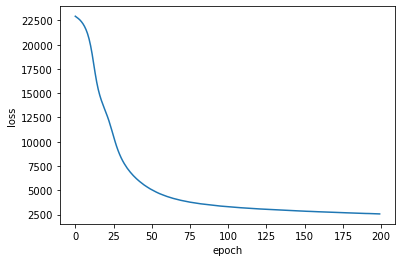

In [36]:
plt.plot(history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

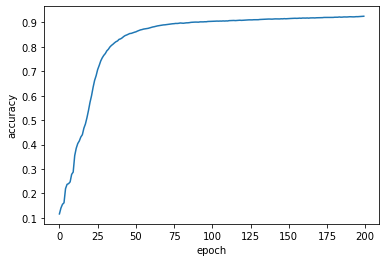

In [38]:
plt.plot(history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()